In [1]:
%cd ~/code/projects/nn-play/
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from IPython.display import HTML
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')
from balls_sim import World, DEFAULT_SIM_CONFIG
from particle_filter import ParticleFilter  # see here for implementational details

gif_counter = 0

/home/ira/code/projects/nn-play


### Prepare nets

In [3]:
import torch
from torch.autograd import Variable
from torch_nets import *
import torch_nets_tests

In [ ]:
torch_nets_tests.train_PAEGAN(2, train_gan=False, train_av=False)

Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/train.pt
Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/test.pt


  0%|          | 0/10000 [00:00<?, ?it/s]/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
 55%|█████▌    | 5529/10000 [01:43<01:32, 48.56it/s, epoch=[2/225], pae train loss=0.000361, pae valid loss=0.0135] 

In [4]:
pae = VisualPAEGAN()
pae.load_state_dict(torch.load('experiments/paegan-stolen/paegan_epoch_26.pth'))

/home/ira/code/projects/nn-play/particle_filter.py:68: RuntimeWarning: invalid value encountered in true_divide
  self.w /= np.sum(self.w)
/home/ira/code/projects/nn-play/particle_filter.py:72: RuntimeWarning: invalid value encountered in less
  samples_i = np.random.choice(indices, self.n, p=self.w)


size torch.Size([160, 1, 256])
size torch.Size([160, 1, 1, 28, 28])


/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Uninformative baseline level at 0.012006248347461224


Ground truth,Particle Filter,PF Sample,Predictive Autoencoder,PAE Sample
,,,,


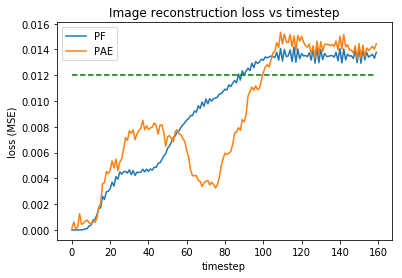

In [5]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 1

w = World(**conf)
gif_counter += 1

pf = ParticleFilter(conf, n_particles=10)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_pf_belief = []
ims_pf_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

RUN_LENGTH = 160

for i in range(RUN_LENGTH):
    if i < 8:
        measures = [body.pos for body in w.bodies]
        pf.update(measures)
        pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[0].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_pf_belief.append(belief)
    ims_pf_sample.append(sample)

    
# run predictions with the network
x = np.array(ims_percept)
x = x.reshape((1, 160, 28, 28, 1))
x[:,8:, ...] = 0
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
# x = x.cuda()
x = Variable(x)
states = pae.bs_prop(x)

# create expected observations
obs_expectation = pae.decoder(states)
obs_expectation = obs_expectation.view(x.size())

obs_expectation = obs_expectation.data.cpu().numpy()
obs_expectation = obs_expectation.reshape((RUN_LENGTH, 28, 28))


# create observation samples
noise = Variable(torch.FloatTensor(RUN_LENGTH, N_SIZE))
noise.data.normal_(0, 1)

print('size', states.size())
#states_non_ep = states.unfold(0, 1, (EP_LEN*BATCH_SIZE)//GAN_BATCH_SIZE).squeeze(-1)

pae_samples = pae.G(noise, states.squeeze_(1))
pae_samples = pae_samples.view(x.size())
print('size', pae_samples.size())

pae_samples = pae_samples.data.cpu().numpy()
pae_samples = pae_samples.reshape((RUN_LENGTH, 28, 28))

pae_ims = []
pae_samples_ims = []
loss_pae = []
for i in range(RUN_LENGTH):
    pae_ims.append(obs_expectation[i, ...])
    pae_samples_ims.append(pae_samples[i, ...])
    loss_pae.append(np.mean((ims_percept[i]-obs_expectation[i, ...])**2))

DURATION = 0.2
imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept, duration=DURATION)
imageio.mimsave("ims/{}-pf_belief.gif".format(gif_counter), ims_pf_belief, duration=DURATION)
imageio.mimsave("ims/{}-pf_sample.gif".format(gif_counter), ims_pf_sample, duration=DURATION)
imageio.mimsave("ims/{}-pae_belief.gif".format(gif_counter), pae_ims, duration=DURATION)
imageio.mimsave("ims/{}-pae_sample.gif".format(gif_counter), pae_samples_ims, duration=DURATION)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Uninformative baseline level at {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_pae)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["PF", "PAE"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Particle Filter</th> 
    <th>PF Sample</th> 
    <th>Predictive Autoencoder</th>
    <th>PAE Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-pf_belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-pf_sample.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_belief.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_sample.gif" width="140"></td>
    
  </tr>

</table>""".format(gif_counter))